In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [35]:
#Loading the dataset
data = pd.read_csv('trading_data.csv')
data.head(5)

,Transaction_no,Transaction_date,Trader_ID,Option_type,Option_group,Option_detail,Price,Quantity
0,1,21/02/2018,1008,CALL,Equity,CALL at 196.0000 on 2016-02-19,1.18,12
1,2,21/02/2018,1004,PUT,Currency,PUT at 182.0000 on 2016-01-29,0.05,1
2,3,21/02/2018,1006,CALL,Equity,CALL at 190.0000 on 2016-02-05,2.65,1
3,4,21/02/2018,1003,PUT,Equity,PUT at 187.0000 on 2016-02-05,1.46,16
4,5,21/02/2018,1003,PUT,Equity,PUT at 179.0000 on 2016-02-19,0.94,18


In [36]:
#Converting the datatype to "Categoory so it can be one-hot encoded"
data['Option_type'] = data['Option_type'].astype('category')
data['Option_group'] = data['Option_group'].astype('category')
data['Trader_ID'] = data['Trader_ID'].astype('category')

data['Transaction_date'] = pd.to_datetime(data['Transaction_date'],format="%d/%m/%Y")
data.dtypes

Transaction_no               int64
Transaction_date    datetime64[ns]
Trader_ID                 category
Option_type               category
Option_group              category
Option_detail               object
Price                      float64
Quantity                     int64
dtype: object

In [37]:
#For visualization, changing date format
data['time_for_plot'] = (data['Transaction_date'].astype(np.int64)/100000000000).astype(np.int64)
data_features = data[['Option_type','Option_group', 'Price','Quantity']]
data_features.head()

,Option_type,Option_group,Price,Quantity
0,CALL,Equity,1.18,12
1,PUT,Currency,0.05,1
2,CALL,Equity,2.65,1
3,PUT,Equity,1.46,16
4,PUT,Equity,0.94,18


In [38]:
#from sklearn.preprocessing import LabelEncoder, OneHotEncoder

#label_encoder = LabelEncoder()
#data["Option_type_coded"] = label_encoder.fit_transform(data["Option_type"])

#One hot encoding
encoded_data = pd.get_dummies(data=data_features, columns=['Option_group', 'Option_type'])
encoded_data.head(5)

,Price,Quantity,Option_group_Bond,Option_group_Currency,Option_group_Equity,Option_group_Future,Option_group_Index,Option_type_CALL,Option_type_PUT
0,1.18,12,0,0,1,0,0,1,0
1,0.05,1,0,1,0,0,0,0,1
2,2.65,1,0,0,1,0,0,1,0
3,1.46,16,0,0,1,0,0,0,1
4,0.94,18,0,0,1,0,0,0,1


In [39]:
from sklearn import preprocessing

#Normalising the data
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(encoded_data)
encoded_data = pd.DataFrame(np_scaled)
encoded_data.head()

,0,1,2,3,4,5,6,7,8
0,-0.556907,-0.372212,-0.5,-0.403473,1.687055,-0.5,-0.5,1.040833,-1.040833
1,-1.156016,-0.492989,-0.5,2.478479,-0.592749,-0.5,-0.5,-0.960769,0.960769
2,0.222466,-0.492989,-0.5,-0.403473,1.687055,-0.5,-0.5,1.040833,-1.040833
3,-0.408455,-0.328293,-0.5,-0.403473,1.687055,-0.5,-0.5,-0.960769,0.960769
4,-0.684151,-0.306334,-0.5,-0.403473,1.687055,-0.5,-0.5,-0.960769,0.960769


In [40]:
from sklearn.decomposition import PCA

#Principal component analysis to reduce dimensions to 1 column
pca = PCA(n_components=1)
pca.fit(encoded_data)
pca_components = pca.transform(encoded_data)

pca_components_df = pd.DataFrame(pca_components)
pca_components_df.index = pca_components_df.index
pca_components_df.columns = ['PC1']
pca_components_df.head()

,PC1
0,-2.077459
1,1.379080
2,-2.128456
3,0.317278
4,0.328483


In [43]:
from sklearn.ensemble import IsolationForest

#Machine learning model
model = IsolationForest(contamination = 0.07) 
model.fit(pca_components_df)
data['anomaly'] = pd.Series(model.predict(pca_components_df)) 
data['anomaly'] = data['anomaly'].map( {1: 0, -1: 1} ) 
print(data['anomaly'].value_counts()) 
print(data.loc[data['anomaly'] == 1])


0    46
1     4
Name: anomaly, dtype: int64
    Transaction_no Transaction_date Trader_ID Option_type Option_group  \
7                8       2018-02-21      1010        CALL       Equity   
17              18       2018-02-22      1005        PUT         Index   
44              45       2018-02-25      1003        CALL       Equity   
46              47       2018-02-26      1006        PUT        Future   

                      Option_detail  Price  Quantity  time_for_plot  anomaly  
7    CALL at 190.5000 on 2016-01-29   1.20        49       15191712        1  
17    PUT at 188.0000 on 2016-03-18   5.27       400       15192576        1  
44   CALL at 193.0000 on 2016-02-12   1.81        45       15195168        1  
46    PUT at 175.0000 on 2016-03-18   1.99       492       15196032        1  


In [9]:
#fig, ax = plt.subplots()

#a = data.loc[data['anomaly'] == 1, ['time_for_plot', 'Quantity']] #anomaly

#ax.plot(data['time_for_plot'], data['Quantity'], color='blue')
#ax.scatter(a['time_for_plot'],a['Quantity'], color='red')
#plt.show()

C:\Users\Shruthi\Anaconda2\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


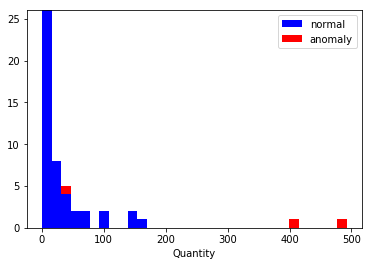

In [10]:
#Plotting suspicious/normal trade data with respect to quantity
#Suspicious trades traded in larger quantity
a = data.loc[data['anomaly'] == 0, 'Quantity']
b = data.loc[data['anomaly'] == 1, 'Quantity']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label = ['normal', 'anomaly'])
plt.legend()
plt.xlabel('Quantity')
plt.show()

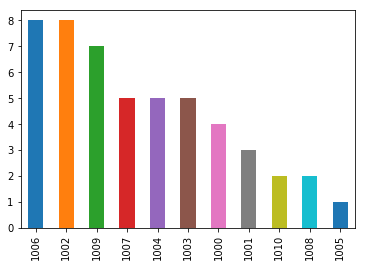

In [13]:
data['Trader_ID'].value_counts().plot(kind='bar')